In [2]:
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

In [ ]:
# https://en.wikipedia.org/wiki/Gaussian_quadrature
# pick the rats that fall along the gaussian quadrature - best approximate of the curve

In [3]:
df = pd.DataFrame(np.random.randint(0,100,size=(500, 2)), columns=list('xy'))
df['Sex'] = [random.choice(['m', 'f']) for i in range(len(df.index))]
df.Sex.value_counts()
df2 = df.copy()

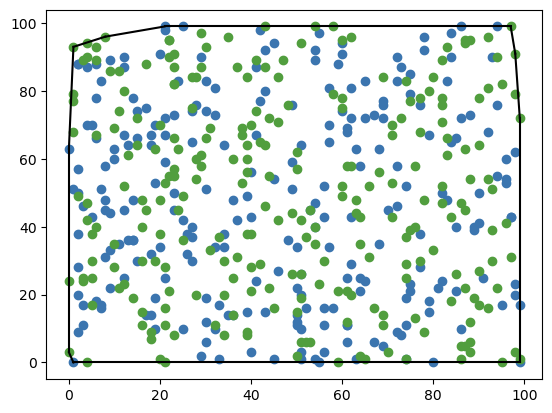

In [4]:
hull = ConvexHull(df.drop(['Sex'], axis=1))
plt.scatter(df[df.Sex=='m'].x, df[df.Sex=='m'].y, color='#3B75AF')
plt.scatter(df[df.Sex=='f'].x, df[df.Sex=='f'].y, color='#519E3E')
for simplex in hull.simplices:
    plt.plot(df.x[simplex], df.y[simplex], 'k-')

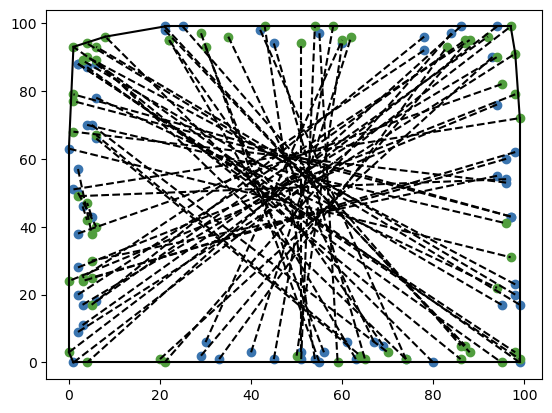

In [9]:
hull = ConvexHull(df.drop(['Sex'], axis=1))
plt.scatter(df[df.Sex=='m'].x, df[df.Sex=='m'].y, color='#3B75AF')
plt.scatter(df[df.Sex=='f'].x, df[df.Sex=='f'].y, color='#519E3E')
for simplex in hull.simplices:
    plt.plot(df.x[simplex], df.y[simplex], 'k-')
for pair in pairs:
    plt.plot([pair[0][0], pair[1][0]], [pair[0][1], pair[1][1]], 'k--')
plt.show()

In [1]:
# algorithmn 1
# choose random points
# calculate convex hull
# find points inside hull, remove them, and try to spread the hull out 
# (pick new points that are further away from center of hull)

In [ ]:
#random
#circular breeding
#breeder a algorithm - maximize distances, limit 1 per family
# simulate breeding algorithms on populations w/ generated allele frequencies and snps
# https://research.uci.edu/wp-content/uploads/JAX-breeding-strategies.pdf
# https://pubmed.ncbi.nlm.nih.gov/31512216/
#https://en.wikipedia.org/wiki/Gaussian_quadrature

In [5]:
def _centroid_poly(poly):
    
    T = Delaunay(poly).simplices
    n = T.shape[0]
    W = np.zeros(n)
    C = 0
    
    for m in range(n):
        sp = poly[T[m, :], :]
        W[m] = ConvexHull(sp).volume
        C += W[m] * np.mean(sp, axis=0)
    
    return C / np.sum(W)

# will calculate the centroid of the convex hull of poly
centroid_hull = _centroid_poly(df.drop(['Sex'], axis=1).to_numpy())
centroid_hull

array([49.72748815, 49.08523937])

In [6]:
def max_1d_dist(centroid, point):
    m = 0
    for i in range(len(centroid)):
        m = max(m, abs(centroid[i] - point[i]))
    return m

In [7]:
# algrithmn 2
# find convex hull area of everything
# take points out and see how much convex hull decreases
# pick the one that decreased the volume the least and move on
start = ConvexHull(df.drop(['Sex'], axis=1)).volume
while len(df.index) > 128:
    centroid = _centroid_poly(df.drop(['Sex'], axis=1).to_numpy())
    
    #maxvolume = maximizing volume keeping, maxdist = maximizing distance away from center after max volume
    maxvolume, mindist, maxid = 0, 0, 0
    
    for n in range(len(df.index)):
        if df.loc[n].Sex != df.Sex.mode()[0] and not len(df.Sex.mode().index) > 1: continue
        hull = ConvexHull(df.drop(['Sex'], axis=1).drop(n))
        if hull.volume > maxvolume: 
            maxvolume = hull.volume
            mindist = max_1d_dist(centroid, df.loc[n][['x', 'y']].to_numpy())
            maxid = n
        elif hull.volume == maxvolume:
            currdist = max_1d_dist(centroid, df.loc[n][['x', 'y']].to_numpy())
            if currdist < mindist: 
                mindist = currdist
                maxid = n
        
    df.drop([maxid], axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
end = ConvexHull(df.drop(['Sex'], axis=1)).volume
print(end/start)

#euclidean dist np.linalg.norm(centroid - df.loc[n][['x', 'y']].to_numpy())
#curr formula takes the ones that are furthest away in a single direction
#problem: can overcount one direction's extreme if all points there are extreme

# this needs to get sped up <--

1.0


In [8]:
# need to stop deleting - keep ids to match
pairs = []
males = df[df.Sex=='m'][['x', 'y']].to_numpy()
maleids = df[df.Sex=='m'].index
females = df[df.Sex=='f'][['x', 'y']].to_numpy()
femaleids = df[df.Sex=='f'].index
for i in range(len(males)):
    maxdist = 0
    maxpair, maxids = (), ()
    for i, m in enumerate(males):
        for j, f in enumerate(females):
            dist = np.linalg.norm(np.array(m) - np.array(f))
            if dist > maxdist:
                maxdist = dist
                maxpair = (m, f)
                maxids = (i, j)
    pairs.append((maxpair[0], maxpair[1]))
    females = np.delete(females, maxids[1], 0)
    males = np.delete(males, maxids[0], 0)

In [10]:
keep = pd.DataFrame(columns=['x', 'y', 'Sex'])
start = df2.copy()
while True:
    
    hull = ConvexHull(start.drop(['Sex'], axis=1))
    keep = pd.concat([keep, start.iloc[hull.vertices]])
    start.drop(hull.vertices, inplace=True)
    start.reset_index(drop=True, inplace=True)
    
    if len(keep.index) > 128 and keep.Sex.value_counts()[0] > 64 and keep.Sex.value_counts()[1] > 64: break
keep.reset_index(drop=True, inplace=True)

In [11]:
keep['breed'] = False
pairs = []
males = keep[keep.Sex=='m'][['x', 'y']].to_numpy()
maleids = np.array(keep[keep.Sex=='m'].index)
females = keep[keep.Sex=='f'][['x', 'y']].to_numpy()
femaleids = np.array(keep[keep.Sex=='f'].index)
for _ in range(64):
    maxdist = 0
    maxpair, maxids = (), ()
    for i, m in enumerate(males):
        for j, f in enumerate(females):
            dist = np.linalg.norm(np.array(m) - np.array(f))
            if dist > maxdist:
                maxdist = dist
                maxpair = (m, f)
                maxids = (i, j)
    keep.loc[maleids[maxids[0]], 'breed'] = True
    keep.loc[femaleids[maxids[1]], 'breed'] = True
    pairs.append((maxpair[0], maxpair[1]))
    females = np.delete(females, maxids[1], 0)
    males = np.delete(males, maxids[0], 0)
    femaleids = np.delete(femaleids, maxids[1], 0)
    maleids = np.delete(maleids, maxids[0], 0)

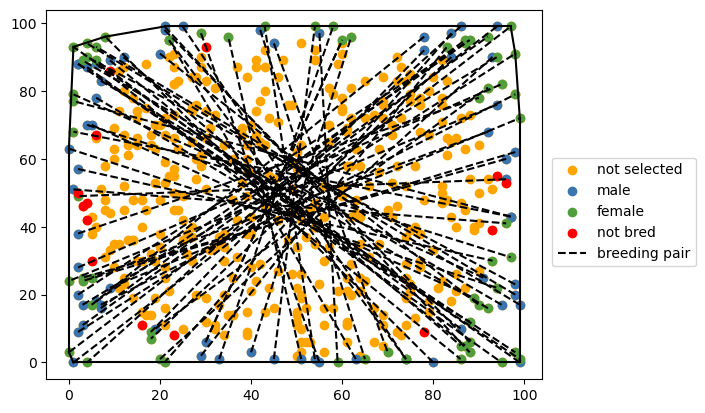

In [12]:
hull = ConvexHull(keep.drop(['Sex', 'breed'], axis=1))
breed = keep[keep.breed == True]
nobreed = keep[keep.breed == False]
plt.scatter(df2.x, df2.y, color='orange', label='not selected')
plt.scatter(breed[breed.Sex=='m'].x, breed[breed.Sex=='m'].y, color='#3B75AF', label='male')
plt.scatter(breed[breed.Sex=='f'].x, breed[breed.Sex=='f'].y, color='#519E3E', label='female')
plt.scatter(nobreed.x, nobreed.y, color='red', label='not bred')
for simplex in hull.simplices:
    plt.plot(keep.x[simplex], keep.y[simplex], 'k-')
for pair in pairs:
    plt.plot([pair[0][0], pair[1][0]], [pair[0][1], pair[1][1]], 'k--')
plt.plot([pair[0][0], pair[1][0]], [pair[0][1], pair[1][1]], 'k--', label='breeding pair')
plt.legend(bbox_to_anchor=(1.02, 0.6), loc='upper left', borderaxespad=0)
plt.show()

<div>
<img src="attachment:88b317ea-9890-434b-99af-86e330d2742c.png" width="275"/>
<img src="attachment:75015e41-1dbf-48b8-bb00-a812f9c71486.png" width="275"/>
<img src="attachment:a0fbcc4d-beb1-43af-b2ea-884a03a2c147.png" width="275"/>
</div>

In [ ]:
# max distance between pairs
# brute force way is to find all the dif possibilities of pair groups and maximize total distance from that
# slightly easier way of doing it is to find the max total distance and then take out those rats, then do it for the rest
# slight problem i see w/ that way of doing it is that you could be slightly better not having top two rats together

In [270]:
# other idea - max females and male convex hulls separately
# then max total dist between male/female pairs, only taking the top half pairs (so get x2 females/males)